# Notebook to develop the model for the project

# List of ideas to improve the network

0. ## start with easier polynomials
1. ## Add a grid with finer blocks to the input as transform
2. ## Revise the architecture
3. ## Add dropout to the network
4. ## Find a way to measure accuracy of multiple regression network with some tolerance factor, as well as explore statiscal measure of error such as standard deviation, p-value, r-square etc
5. ## apply crossvalidation to the training loop
6. ## List all hyperparameters of the network (affecting net performance)
    >### Learning rate, number of epochs, batch size, Dropout rate
    >### Loss function, Optimizer, Network architecture
    >### CNN layers NofElement, arrangment, and parameters
    >### FC layers NofElement, arrangment, and parameters
7. ## Build a much larger much richer dataset with transforms to more than 10^5 sample, that is statistically sound (no extreme bias, etc...)
8. ## Apply planned data augmentation transforms
<!-- 9. ## Use a genetic algorithm to search best set of hyper parameters 
    >### Encode all hyperparameters listed into a string represention "chromosome/gene"
    >### Use the new measure of accuracy to gauge the "fitness" of the net
    >### Design a function to allow for "crossover" between nets' genes 
    >### Design a "mutation" function that allows for variations in hyperparameters.
    >### Put the environment together to run the algorithm
  -->
9. ## Explore Self-Attention and Auto-Encoders

In [1]:
# All our imports
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
import PIL
import os

#for all the plots to be inline
%matplotlib inline 


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.values[index][0]
        labels = np.array([1, 1, 1, 1, 1, 1, 1, 1])
        for x in range(0, 8):
            labels[x] = self.df.values[index][x+1]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, labels


In [18]:
# Select device to train on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = 'cpu'

cuda:0


In [8]:
'''Data Set manipulation'''
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

# windows pathss
# root = "C:\\Users\\the_3\Desktop"
# trainDataset = CustomDataset(root + "\\poly-curve-detector\\data\\plotData\\labels\\trainPlots.csv",
#                                root + "\\poly-curve-detector\\data\\plotData\\trainPlots", transform)

# testDataset = CustomDataset(root + "\\poly-curve-detector\\data\\plotData\\labels\\testPlots.csv",
#                                root + "\\poly-curve-detector\\data\\plotData\\testPlots", transform)


# linux paths
root = "/home/erud1t3/Desktop"
trainDataset = CustomDataset(root + "/poly-curve-detector/data/plotData/labels/trainPlots.csv",
                               root + "/poly-curve-detector/data/plotData/trainPlots", transform)

testDataset = CustomDataset(root + "/poly-curve-detector/data/plotData/labels/testPlots.csv",
                               root + "/poly-curve-detector/data/plotData/testPlots", transform)

#print first label in each dataset
#labels in order [a1,a2,a3,a4,a5,a6,a7,a8]
# image, labels = trainDataset[0]
# print(labels[0:9])
# image, labels = testDataset[0]
# print(labels[0:9])

In [19]:
batchsize = 128
train_set = torch.utils.data.DataLoader(trainDataset, shuffle=True, batch_size=batchsize)
test_set = torch.utils.data.DataLoader(testDataset, shuffle=False, batch_size=batchsize)

torch.Size([128, 3, 96, 96]) torch.Size([128, 8])
Train Set 0
Image: tensor([[[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]],

        [[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]],

        [[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000

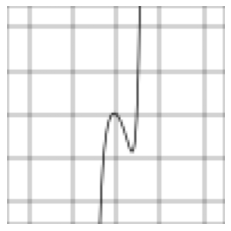

torch.Size([128, 3, 96, 96]) torch.Size([128, 8])
Test Set 0
Image: tensor([[[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]],

        [[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]],

        [[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000,

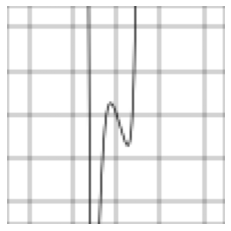

In [20]:
#one way to see batch size
train_batch = next(iter(train_set))
img, lbls = train_batch
print(img.shape, lbls.shape)

#display the first image in train_set
#note: image changes each time run because shuffle is set to true
for images, labels in train_set:
    image, label = images[0], labels[0]
    print(f"Train Set 0\nImage: {image}\nLabels: {label}\n")
    print(image.shape, label.shape)
    figure = plt.figure(figsize=(4,4))
    figure.add_subplot()
    plt.axis("off")
    plt.imshow(image.permute(1,2,0), cmap="gray")
    plt.show()
    break
    
#test batch size
test_batch = next(iter(test_set))
img, lbls = test_batch
print(img.shape, lbls.shape)

#display the first image in test_set
for images, labels in test_set:
    image, label = images[0], labels[0]
    print(f"Test Set 0\nImage: {image}\nLabels: {label}\n")
    print(image.shape, label.shape)
    figure = plt.figure(figsize=(4,4))
    figure.add_subplot()
    plt.axis("off")
    plt.imshow(image.permute(1,2,0), cmap="gray")
    plt.show()
    break

In [7]:
# class Network(nn.Module):
#     def __init__(self):
#         super(Network, self).__init__()
#         # more analysis required to determine the specifics of the architecture
       
#         self.n_output = 8
#         self.n_channel = 1
    
#         self.cnn_layers = nn.Sequential(
#                 nn.Conv2d(1, 8, 3), # convolution2dLayer(3,8,'Padding','same')
#                 nn.BatchNorm2d(8),   # batchNormalizationLayer
#                 nn.LeakyReLU(), # reluLayer
#                 nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
#                 nn.Conv2d(8, 16, 3), # convolution2dLayer(3,16,'Padding','same')
#                 nn.BatchNorm2d(16), # batchNormalizationLayer
#                 nn.LeakyReLU(), # reluLayer
#                 nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
#                 nn.Conv2d(16, 32, 3), # convolution2dLayer(3,32,'Padding','same')
#                 nn.BatchNorm2d(32), # batchNormalizationLayer
#                 nn.LeakyReLU(), # reluLayer
#                 nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
#                 nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
#                 nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
#                 nn.BatchNorm2d(32), # batchNormalizationLayer
#                 nn.LeakyReLU(), # reluLayer
#                 nn.MaxPool2d(2, 2) # Max pooling layer
#         )

#         self.n_input = 1568 # the output of maxpool 96*96 
#         #DONE:actual value might be determined from the computed output of the cnn layers
#         # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

#         self.fc_layers = nn.Sequential(
#         #   fullyConnectedLayer(1)
#             nn.Linear(self.n_input,  4096),
#             nn.LeakyReLU(),
#             nn.Dropout(p=.5),
#             nn.Linear(4096, 4096),
#             nn.LeakyReLU(),
#             nn.Dropout(p=.3),
#             nn.Linear(4096, 128),
#             nn.LeakyReLU(),
#             nn.Dropout(p=.3),
#             nn.Linear(128, 64),
#             nn.LeakyReLU(),
#             nn.Dropout(p=.1),
#             nn.Linear(64, self.n_output),
#             nn.LeakyReLU()
#         )


# #         regressionLayer
#         self.criterion = nn.MSELoss()       
# #    

        
#     def forward(self, x):
#         #feedword pass through our network
#         x = self.cnn_layers(x)
#         x = x.view(x.shape[0], -1) #flatten the input tensor
#         x = self.fc_layers(x)
        
#         return x


#     @staticmethod
#     def load_checkpoint(new_model, filepath):
#         checkpoint = torch.load(filepath)
#         # model = checkpoint['model']
#         new_model.load_state_dict(checkpoint['state_dict'])
#         return new_model
    
#     def save(self, dirpath):
#         self.checkpoint = {
#         #     'input_size': self.n_input, 
#         #     'output_size': self.n_output,
#         #     'cnn_layers': [each. for each in model.cnn_layers],
#         #     'fc_layers': [each.out_features for each in model.fc_layers],
#             'state_dict': model.state_dict()
#         }
#         torch.save(self.checkpoint, f'{dirpath}\\model_checkpoint.pth')

# model = Network() 


In [21]:
# Transfer learning approach
model = models.densenet121(pretrained=True)
model


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [23]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
  param.requires_grad = False

fc_layers = nn.Sequential(
#   fullyConnectedLayer(1)
  nn.Linear(1024,  1024),
  nn.LeakyReLU(),
  nn.Dropout(p=.5),
  nn.Linear(1024, 512),
  nn.LeakyReLU(),
  nn.Dropout(p=.3),
  nn.Linear(512, 8),
  nn.LeakyReLU()
)
# classifier = nn.Sequential(
#   nn.Linear(25088, 4096),
#   nn.ReLU(),
#   nn.Dropout(.5),
#   nn.Linear(4096, 102),
#   nn.LogSoftmax(dim=1)
# )
    
model.classifier = fc_layers

In [46]:
# Measure of accuracy
# create a nn class (from https://discuss.pytorch.org/t/rmse-loss-function/16540/3)
class Measure_Acc(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,predicted, target):
        rmse = torch.sqrt(self.mse(predicted, target))
        rmse_norm = rmse /  20. # normalization 20 = 10 - (-10)
        # print('rmse normal =', rmse_norm)
        accuracy = 100 * (1 - rmse_norm)
        return accuracy

rmse_accuracy = Measure_Acc()

In [47]:
    
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:
        # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
        # images = images.view(images.shape[0], -1)
        labels = labels.float()
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)

        # print(f'output={output.shape}')
        # print(f'label={labels.shape}')
        test_loss += criterion(output, labels)
        accuracy += rmse_accuracy(output, labels)

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):

    steps = 0
    running_loss = 0
    test_losses = []
    train_losses = []
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
            # Flatten images into a 784 long vector
            # images = images.view(images.shape[0], -1)
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            output = model.forward(images)
            # print(f'output={output.shape}')
            # print(f'label={labels.shape}')
            loss = criterion(output, labels)
            loss.backward() # computes gradient and backpropagation
            optimizer.step() # update of weights and biases happenss
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Accuracy: {:.3f}".format(accuracy/len(testloader))
                      )
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()
    plt.ylim([0, 50])          
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)

In [48]:
# model = Network()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

train(
    model=model, 
    trainloader=train_set, 
    testloader=test_set, 
    criterion=nn.MSELoss(),
    optimizer=optim.Adam(model.classifier.parameters(), lr=.001),
    epochs=1500, 
    print_every=10
)


Epoch: 1/1500..  Training Loss: 28.355..  Test Loss: 30.197..  Accuracy: 31.620
Epoch: 1/1500..  Training Loss: 29.223..  Test Loss: 30.263..  Accuracy: 31.660
Epoch: 1/1500..  Training Loss: 29.532..  Test Loss: 29.717..  Accuracy: 31.332
Epoch: 2/1500..  Training Loss: 28.056..  Test Loss: 29.547..  Accuracy: 31.229
Epoch: 2/1500..  Training Loss: 28.280..  Test Loss: 29.622..  Accuracy: 31.275
Epoch: 2/1500..  Training Loss: 28.560..  Test Loss: 29.701..  Accuracy: 31.322
Epoch: 3/1500..  Training Loss: 27.670..  Test Loss: 30.336..  Accuracy: 31.703


Output tensor: [ 5.1332086e-02 -3.9833851e-02 -3.5277724e-02 -2.2666082e-03
  8.6983180e-01 -3.1259311e-03 -1.3115698e-02  5.0131006e+00]
Output curve: 


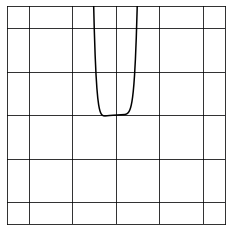

Actual label tensor: [-3 -2  5 -7  9  4  2  8]
Actual curve: 


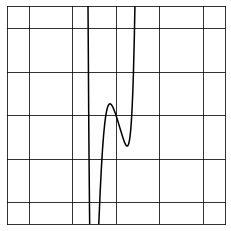

In [29]:
test_batch = next(iter(test_set))
img, lbls = test_batch
img, lbls = img.to(device), lbls.to(device)
# print(img.shape, lbls.shape)

output = model.forward(img)
#print(output)
#print(lbls)

x = np.linspace(-5, 5, 1000)

output0_coeff = output[0]
output0_coeff = output0_coeff.detach().cpu().numpy()
lbls0_coeff = lbls[0]
lbls0_coeff = lbls0_coeff.detach().cpu().numpy()
fig, ax = plt.subplots()

#display output[0] curve
print(f'Output tensor: {output0_coeff}')
print('Output curve: ')
ax.plot(x, ((output0_coeff[7]*x**8)+(output0_coeff[6]*x**7)+(output0_coeff[5]*x**6)
            +(output0_coeff[4]*x**5)+(output0_coeff[3]*x**4)+(output0_coeff[2]*x**3)
            +(output0_coeff[1]*x**2)+(output0_coeff[0]*x**1)),
            color='#000000')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(left = False, labelleft = False,
                   bottom =  False, labelbottom = False)
ax.grid(color='#000001')

plt.show()

#display actual curve
print(f'Actual label tensor: {lbls0_coeff}')
print('Actual curve: ')
fig, ax = plt.subplots()

ax.plot(x, ((lbls0_coeff[7]*x**8)+(lbls0_coeff[6]*x**7)+(lbls0_coeff[5]*x**6)
            +(lbls0_coeff[4]*x**5)+(lbls0_coeff[3]*x**4)+(lbls0_coeff[2]*x**3)
            +(lbls0_coeff[1]*x**2)+(lbls0_coeff[0]*x**1)),
            color='#000000')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(left = False, labelleft = False,
                   bottom =  False, labelbottom = False)
ax.grid(color='#000001')

plt.show()

In [11]:
# Save the network
# model.save('C:\\Users\\the_3\\Desktop\\poly-curve-detector\\Model')


In [ ]:
checkpoint = {
    # 'arch': 'vgg16',
    # 'input_size': 25088,
    # 'output_size': 102,
    # 'hidden_units': 4096,
    'model': model.to(torch.device('cpu')),
    'features': model.features,
    'classifier': model.classifier,
    # 'optimizer': optimizer.state_dict(),
    'state_dict': model.state_dict(),
    # 'idx_to_class': {val: key for key, val in image_datasets.class_to_idx.items()}
}

torch.save(checkpoint,'model/model_checkpoint.pth')

In [12]:
# laod network from save
# net_path = root + "\\poly-curve-detector\\Model\\model_checkpoint.pth"
# new_model = Network()
# Network.load_checkpoint(new_model, net_path)



Network(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, aff

In [ ]:
#  Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path):
    '''give absolute path'''
    checkpoint = torch.load(path)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    return checkpoint, model

checkpoint, model = load_checkpoint('models/model_checkpoint.pth')
print(model)

Output tensor: [ 5.6838956  -8.467546   -6.5452247   0.66510093 -5.0171356   4.685207
 -3.2718596  -3.1595328 ]
Output curve: 


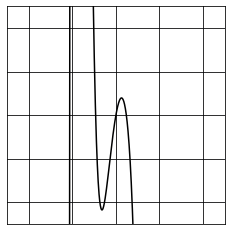

Actual label tensor: [  5 -10  -4   3  -7   7  -9  -7]
Actual curve: 


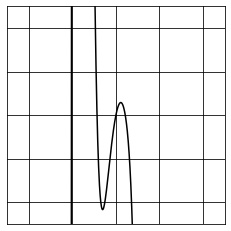

In [17]:
# loaded network from save
test_batch = next(iter(test_set))
img, lbls = test_batch
# img, lbls = img.to(device), lbls.to(device)
# print(img.shape, lbls.shape)

output = new_model.forward(img)
#print(output)
#print(lbls)

x = np.linspace(-5, 5, 1000)

output0_coeff = output[0]
output0_coeff = output0_coeff.detach().cpu().numpy()
lbls0_coeff = lbls[0]
lbls0_coeff = lbls0_coeff.detach().cpu().numpy()
fig, ax = plt.subplots()

#display output[0] curve
print(f'Output tensor: {output0_coeff}')
print('Output curve: ')
ax.plot(x, ((output0_coeff[7]*x**8)+(output0_coeff[6]*x**7)+(output0_coeff[5]*x**6)
            +(output0_coeff[4]*x**5)+(output0_coeff[3]*x**4)+(output0_coeff[2]*x**3)
            +(output0_coeff[1]*x**2)+(output0_coeff[0]*x**1)),
            color='#000000')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(left = False, labelleft = False,
                   bottom =  False, labelbottom = False)
ax.grid(color='#000001')

plt.show()

#display actual curve
print(f'Actual label tensor: {lbls0_coeff}')
print('Actual curve: ')
fig, ax = plt.subplots()

ax.plot(x, ((lbls0_coeff[7]*x**8)+(lbls0_coeff[6]*x**7)+(lbls0_coeff[5]*x**6)
            +(lbls0_coeff[4]*x**5)+(lbls0_coeff[3]*x**4)+(lbls0_coeff[2]*x**3)
            +(lbls0_coeff[1]*x**2)+(lbls0_coeff[0]*x**1)),
            color='#000000')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(left = False, labelleft = False,
                   bottom =  False, labelbottom = False)
ax.grid(color='#000001')

plt.show()